## MCMC For WPGAP Frustrated Phagocytosis Model


Import required packages

In [6]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import odeint
from scipy import stats, integrate
import pickle
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
from dedalus.extras import *
from pymcmcstat import MCMC
from pymcmcstat import MCMC, structures, plotting, propagation
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat.chain import ChainStatistics
import matplotlib.pyplot as plt
import seaborn as sns

np.seterr(over='ignore');
#Suppress most Dedalus output
de.logging_setup.rootlogger.setLevel('ERROR')

import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42
matplotlib.rcParams['font.sans-serif']="Arial"
matplotlib.rcParams['font.family']="sans-serif"
# rcParams['font.sans-serif'] = ['Tahoma']
matplotlib.rcParams.update({'font.size': 16})

Load in score function data

In [4]:
AVG_SF = pickle.load(open("Avg_R2_noscale.pickle", "rb"))
STD_SF = pickle.load(open("STDev_R2_noscale.pickle", "rb"))

SF_radii = AVG_SF[0]
SF_data = np.vstack([AVG_SF[1], [STD_SF[1] for i in range(4)]]).T

Text(0.5, 0, 'Radius ($\\mu m$)')

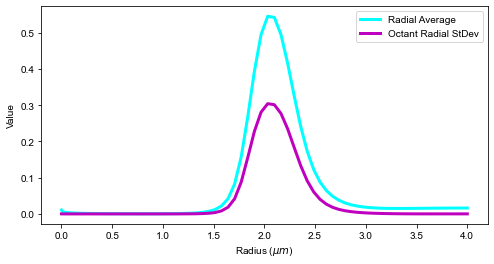

In [5]:
plt.figure(figsize=(8,4))
plt.plot(AVG_SF[0],AVG_SF[1],c='cyan',lw=3)
plt.plot(STD_SF[0],STD_SF[1],c='m',lw=3)

plt.legend(['Radial Average','Octant Radial StDev'])
plt.ylabel('Value')
plt.xlabel('Radius ($\mu m$)')

In [45]:
#Scale list between 0 and 1
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

# steady state ODE
def ssODE(y,t,params):
    u,v,g,G = y
    b,gamma,n,delta,e,c,d = params
    
    du = b*v+v*gamma*u**n/(1+u**n)-delta*u-e*G*u
    dv = -du
    
    dG = c*u*g-d*G
    dg = - dG
    
    derivs = [du,dv,dg,dG]
    return derivs

#determine homogenous SS using ssODE
def homogenousSS(u,v,g,G,params):

    y0 = (u,v,g,G)
    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE,y0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def logistic_decay(x,p_min,p_max,k,x0=1.75):  
    #positive k -> decay
    p_amp = p_max - p_min
    return p_min+p_amp/(1+np.exp(k*(x-x0)))

def WPGAP(params,plot_bool=False):
    c_p,c_m,gamma_p,gamma_m,e,d = params
    
    #Fixed params
    b = 0.0002
    c_s = 0.1
    gamma_s = 0.0005
    delta = 0.04
    
    #Bases:names,modes,intervals,dealiasing
    phi_basis=de.Fourier('p',64,interval=(0,2*np.pi),dealias=3/2)
    r_basis=de.Chebyshev('r',64,interval=(0,4),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([phi_basis,r_basis],float)
    phi, r = domain.grids(scales=1)

    mu_F = 1.75

    c = domain.new_field(name='c')
    gamma = domain.new_field(name='gamma')
    
    c['g'] = logistic_decay(r[0],c_s,c_p,c_m,x0=mu_F) 
    gamma['g'] = logistic_decay(r[0],gamma_s,gamma_p,gamma_m,x0=mu_F)
    
    c.meta['p']['constant'] = True
    gamma.meta['p']['constant'] = True

    T = 4.04
    Tg = 10
    n = 2
    K = 1

    Du = .004 
    Dv = 100*Du
    DG = 100*Du #40
    Dg = 100*Du

    params = [b,np.min(gamma['g']),n,delta,e,np.min(c['g']),d]
#     params = [b_SS,gamma_SS,n,delta,e,c_SS,d]
    u0,v0,g0,G0 = homogenousSS(T/2,T/2, Tg/2, Tg/2,params)


    # Specify problem
    problem = de.IVP(domain, variables=['u', 'v','ur','vr','G','g','Gr','gr'])

    problem.parameters['gamma'] = gamma
    problem.parameters['b'] = b
    problem.parameters['n'] = n
    problem.parameters['u0'] = u0
    problem.parameters['v0'] = v0
    problem.parameters['G0'] = G0
    problem.parameters['g0'] = g0
    problem.parameters['c'] = c
    problem.parameters['dd'] = d
    problem.parameters['delta'] = delta
    problem.parameters['e'] = e
    problem.parameters['K'] = K
    problem.parameters['Tg'] = Tg

    problem.parameters['Du'] = Du
    problem.parameters['Dv'] = Dv
    problem.parameters['DG'] = DG
    problem.parameters['Dg'] = Dg

    problem.substitutions['f(u,v,G)'] = 'b*v+v*gamma*u**n/(K**n+u**n)-delta*u-e*G*u'
    problem.substitutions['minf(u,v,G)'] = '-f(u,v,G)'
    problem.substitutions['fg(u,G,g)'] = 'c*u*g-dd*G'
    problem.substitutions['minfg(u,G,g)'] = '-fg(u,G,g)'


    problem.add_equation("r**2*dt(u)-r**2*Du*dr(ur)-r*Du*dr(u)-Du*dp(dp(u))=r**2*f(u,v,G)")
    problem.add_equation("r**2*dt(v)-r**2*Dv*dr(vr)-r*Dv*dr(v)-Dv*dp(dp(v))=r**2*minf(u,v,G)")
    problem.add_equation("r**2*dt(G)-r**2*DG*dr(Gr)-r*DG*dr(G)-DG*dp(dp(G))=r**2*fg(u,G,g)")
    problem.add_equation("r**2*dt(g)-r**2*Dg*dr(gr)-r*Dg*dr(g)-Dg*dp(dp(g))=r**2*minfg(u,G,g)")

    problem.add_equation("ur-dr(u)=0")
    problem.add_equation("vr-dr(v)=0")
    problem.add_equation("Gr-dr(G)=0")
    problem.add_equation("gr-dr(g)=0")

    #Reflective boundary conditions

    problem.add_bc("left (ur) = 0")
    problem.add_bc("right (ur) = 0")
    problem.add_bc("left (vr) = 0")
    problem.add_bc("right (vr) = 0")
    problem.add_bc("left (Gr) = 0")
    problem.add_bc("right (Gr) = 0")
    problem.add_bc("left (gr) = 0")
    problem.add_bc("right (gr) = 0")


    # Pick a timestepper
    ts = de.timesteppers.RK443 #443
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']
    v = solver.state['v']
    G = solver.state ['G']
    g = solver.state['g']
    u_seed = pickle.load( open( "PR_9Dots.pickle", "rb" ) )
    u_seed_norm = u_seed/np.max(u_seed)
    urand = 0.1*v0*np.random.rand(*u['g'].shape) + 0.1*v0*u_seed_norm

    u['g'] = u0+urand
    v['g'] = v0-urand
    G['g'] = G0*np.ones(G['g'].shape)
    g['g'] = g0*np.ones(g['g'].shape)

    solver.stop_iteration = 400

    dt =  0.25 
    nonan = True
    # Main loop chceking stopping criteria
    while solver.ok and nonan:
        # Step forward
        solver.step(dt)

        if solver.iteration % 50 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                return('Numerical Error')
                nonan = False  
                
    usim = u['g'].T
    
    if plot_bool == True:
        plt.figure()
        phi, r = domain.grids(scales=domain.dealias)
        phi = np.vstack((phi,2*np.pi))
        phi,r = np.meshgrid(phi,r)
        z = np.vstack((u['g'],u['g'][0])).T
        fig = plt.figure()
        # ax = Axes3D(fig)

        plt.subplot(projection="polar")

        plt.pcolormesh(phi,r, z,vmin=0.2, vmax = 1., shading='auto')

        plt.plot(phi, r, color='k', ls='none') 
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
    
    avg_curr = []
    q1_std, q2_std , q3_std , q4_std = [],[],[],[]
    inc = len(usim[0])//4
    for i in range(len(usim)):
        avg_curr.append(np.mean(usim[i]))
        q1_std.append(np.std(usim[i][0:inc]))
        q2_std.append(np.std(usim[i][inc:2*inc]))
        q3_std.append(np.std(usim[i][2*inc:3*inc]))
        q4_std.append(np.std(usim[i][3*inc:4*inc]))
    q1_std = np.array(q1_std)
    q2_std = np.array(q2_std)
    q3_std = np.array(q3_std)
    q4_std = np.array(q4_std)
                
    return np.array([avg_curr,q1_std,q2_std,q4_std,q4_std]).T

#Score function to score each parameter set
def WPGAP_mse(params,mc_data):
    def mse(A,B):
        A = A[~np.isnan(A)]
        B = B[~np.isnan(B)]
        return(np.mean(np.subtract(A,B)**2))
    
    sf_avg = np.array(mc_data.ydata).T[0]
    sf_std = np.array(mc_data.ydata).T[1]
    
    sim_dists = WPGAP(params)
    if np.shape(sim_dists) != (96,5) :
        return(np.ones(5)*np.inf)
    
    sim_avg = np.array(sim_dists.T[0])
    sim_std = np.array(sim_dists.T[1:])
    
    mse_avg = [mse(sf_avg,sim_avg)]
    mse_std = [mse(sf_std,sim_std[i]) for i in range(4)]
    
    return np.hstack([mse_avg,mse_std])

#Score function to score each parameter set
def WPGAP_mse_plot(params,mc_data):
    round_to_n = lambda x, n: round(x, -int(np.floor(np.log10(x))) + (n - 1))
    
    def mse(A,B):
        A = A[~np.isnan(A)]
        B = B[~np.isnan(B)]
        return(np.mean(np.subtract(A,B)**2))
    
    sf_avg = np.array(mc_data.ydata).T[0]
    sf_std = np.array(mc_data.ydata).T[1]
    
    sim_dists = WPGAP(params,plot_bool=True)
    if np.shape(sim_dists) != (96,5) :
        return(np.ones(5)*np.inf)
    
    sim_avg = np.array(sim_dists.T[0])
    sim_std = np.array(sim_dists.T[1:])
    
    mse_avg = [mse(sf_avg,sim_avg)]
    mse_std = [mse(sf_std,sim_std[i]) for i in range(4)]
    
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.title([round_to_n(val,2) for val in mse_avg])
    plt.plot(sf_avg,':',c='k')
    plt.plot(sim_avg)
    
    plt.subplot(1,2,2)
    plt.title([round_to_n(val,2) for val in mse_std])
    plt.plot(sf_std,':',c='k')
    plt.plot(sim_std.T)
    

    return np.hstack([mse_avg,mse_std])


### Initialize MCMC

In [8]:
# initialize MCMC object
mcstat = MCMC.MCMC()


mcstat.data.add_data_set(x=np.arange(0,96),
                         y=SF_data,
                         user_defined_object=SF_radii)

# add model parameters and set prior value and constraints
mcstat.parameters.add_model_parameter(name='c_p', theta0=1.15, minimum=0)
mcstat.parameters.add_model_parameter(name='c_m', theta0=13.29, minimum=1,maximum=50)
mcstat.parameters.add_model_parameter(name='gamma_p', theta0=0.95, minimum=0)
mcstat.parameters.add_model_parameter(name='gamma_m', theta0=1.99, minimum=1,maximum=50)
mcstat.parameters.add_model_parameter(name='e', theta0=3.25, minimum=0)
mcstat.parameters.add_model_parameter(name='d', theta0=4.3, minimum=0)


# Generate options
mcstat.simulation_options.define_simulation_options(
    nsimu=1.0e1, updatesigma=True, 
    verbosity=False,save_to_json=True,
    save_lightly=False,savedir = save_folder,results_filename = save_json, waitbar=False )
# Define model object:
mcstat.model_settings.define_model_settings(
    sos_function=WPGAP_mse,
    nbatch = 9,
    sigma2=0.01**2,S20=0.012*np.ones(9),N0=0.012*np.ones(9))



In [15]:
folder = 'MCMCRun015_Logistic_Best_Fixed_Oct_Cont2_20220206'
# folder = 'MCMCRun02_Diffusion_Best_Oct_20220210'# main diff coupled model sampling

files = os.listdir(folder)
files = [file for file in files if '.json' in file]
files = [folder+'/'+file for file in files]

all_chains = []
all_ss_chains = []
all_s2_chains = []
for o in files:
    print(o)
    results_orig = structures.ResultsStructure.ResultsStructure.load_json_object(o)
    for ii, key in enumerate(results_orig):
        results_orig[key] = np.array(results_orig[key])

    chain = results_orig['chain']
    s2chain = results_orig['s2chain']
    sschain = results_orig['sschain']
    
    all_chains.append(chain)
    all_s2_chains.append(s2chain)
    all_ss_chains.append(np.sum(sschain,axis=1))

    names = results_orig['names']
    print(ChainStatistics.chainstats(chain))
    
all_chains = np.array(all_chains)

MCMCRun015_Logistic_Best_Fixed_Oct_Cont2_20220206/MCMCRun20220206_4639589400.json


------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:      1.56      0.26      0.03    388.90      0.74
   $p_{1}$:     13.40      1.14      0.16    201.23      0.94
   $p_{2}$:      0.94      0.04  5.35e-03    204.99      0.99
   $p_{3}$:      2.01      0.15      0.02    516.26      0.87
   $p_{4}$:      3.16      0.44      0.06    430.61      0.79
   $p_{5}$:      4.28      0.11      0.01    200.06      1.00
------------------------------
Acceptance rate information
Chain provided:
Net    : 37.49% -> 3749/10000
------------------------------
None
MCMCRun015_Logistic_Best_Fixed_Oct_Cont2_20220206/MCMCRun20220206_53789286804.json


------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:      1.55      0.30      0.05    462.24      0.99
   $p_{1}$:     13.17      0.93      0.13    281.80      0.96
   $p_{2



------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:      1.60      0.27      0.04    322.09      0.87
   $p_{1}$:     12.88      1.14      0.19    438.64      0.93
   $p_{2}$:      0.96      0.04  7.03e-03    419.17      0.97
   $p_{3}$:      2.05      0.15      0.02    315.87      0.92
   $p_{4}$:      3.10      0.41      0.07    315.04      0.89
   $p_{5}$:      4.30      0.10      0.01    223.99      0.99
------------------------------
Acceptance rate information
Chain provided:
Net    : 35.04% -> 3504/10000
------------------------------
None
MCMCRun015_Logistic_Best_Fixed_Oct_Cont2_20220206/MCMCRun20220206_19402712247.json


------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:      1.71      0.38      0.07    535.80      0.90
   $p_{1}$:     13.23      1.08      0.16    310.61      0.92
   $p_{2}$:      0.95      0.04  5.07e-03    261.66      0.97
   $p_{3}$:      2.09      0

In [16]:
#Post burn-in

for i in range(np.shape(all_chains)[0]):
        bi_chain = all_chains[i][5000:]
        print(i,ChainStatistics.chainstats(bi_chain))




------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:      1.46      0.24      0.03    168.97      0.96
   $p_{1}$:     13.56      1.36      0.24    194.82      0.86
   $p_{2}$:      0.94      0.05  8.28e-03    210.64      0.93
   $p_{3}$:      1.96      0.14      0.02    103.84      0.99
   $p_{4}$:      3.30      0.45      0.07    258.20      0.93
   $p_{5}$:      4.28      0.12      0.02    214.78      0.98
------------------------------
Acceptance rate information
Chain provided:
Net    : 34.88% -> 1744/5000
------------------------------
0 None


------------------------------
      name:      mean       std    MC_err       tau    geweke
   $p_{0}$:      1.56      0.36      0.07    553.83      0.81
   $p_{1}$:     13.26      1.08      0.20    310.02      0.99
   $p_{2}$:      0.95      0.04  7.19e-03    277.66      0.99
   $p_{3}$:      2.01      0.20      0.04    545.90      0.93
   $p_{4}$:      3.21      0.58      0.12    552

In [31]:
# params = [r'$c_{max}$',r'$c_{k_m}$',r'$\gamma_{max}$',r'$\gamma_{k_m}$','$e$','$d$'] #for plotting
params = ['c_max','c_km','gamma_max','gamma_km','e','d']

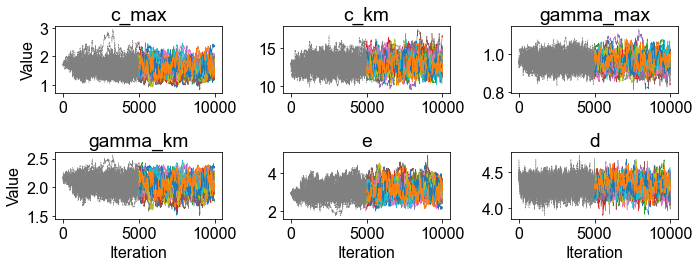

In [32]:
plt.figure(figsize=(10,4))
for k in range(np.shape(all_chains)[2]):
    plt.subplot(2,3,k+1)
    plt.title('%s'%params[k])
    for i in range(np.shape(all_chains)[0]):
        if i in [201]:#[0,2,3,4,5,12,13,15,16,19,20,21,22,23,24,25]:
            continue
            cut_off = 0#5000
            plt.plot(range(cut_off),all_chains[i,:,k][:cut_off],'gray',ls='--',lw=0.5)
            plt.plot(range(cut_off,len(all_chains[0])), all_chains[i,:,k][cut_off:],'limegreen',lw=0.5)
            continue
            
        cut_off = 5000
        plt.plot(range(cut_off),all_chains[i,:,k][:cut_off],'gray',ls='--',lw=0.5)
        plt.plot(range(cut_off,len(all_chains[0])), all_chains[i,:,k][cut_off:],lw=0.5)
        

        if k%3 == 0:
            plt.ylabel('Value')
            
        if k>2:
            plt.xlabel('Iteration')
            
#         plt.scatter(0,means[k],c='r',s=20)
#         plt.xticks([0,1000])
        plt.xticks([0,5000,10000])

        
# plt.legend(range(np.shape(all_chains)[0]))
plt.tight_layout()

# plt.savefig('MCMC_Figures/MCMC_Chains_wBurnIn.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('MCMC_Figures/MCMC_Chains_wBurnIn.png',dpi=300,bbox_inches='tight')

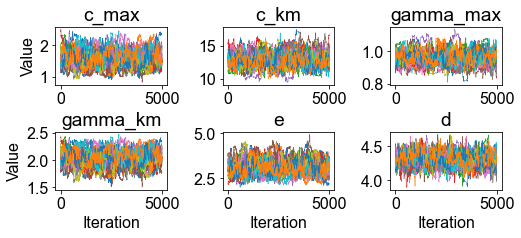

In [33]:
plt.figure(figsize=(8,3))
for k in range(np.shape(all_chains)[2]):
    plt.subplot(2,3,k+1)
    plt.title('%s'%params[k])
    for i in range(np.shape(all_chains)[0]):
        cut_off = 5000
        plt.plot(all_chains[i,:,k][cut_off:],lw=0.5)
    
        if k%3 == 0:
            plt.ylabel('Value')
            
        if k>2:
            plt.xlabel('Iteration')
        plt.xticks()

plt.subplots_adjust(wspace=0.5,hspace=0.8)

# plt.savefig('MCMC_Figures/MCMC_Chains.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('MCMC_Figures/MCMC_Chains.png',dpi=300,bbox_inches='tight')

plt.show()

In [34]:
burn_in_chains = np.array([c[5000:] for i,c in enumerate(all_chains)]) #cont2

bi_all_chains = np.vstack(burn_in_chains)

In [35]:
# gr = ChainStatistics.gelman_rubin(subset)

In [36]:
all_ss_chains_subset = np.vstack([c[:][5000:] for c in all_ss_chains])
worst_i = np.argmax(np.hstack(all_ss_chains_subset))
worst = bi_all_chains[worst_i] #worst scoring parameter set

In [37]:
closest = np.mean(bi_all_chains,axis=0) #mean

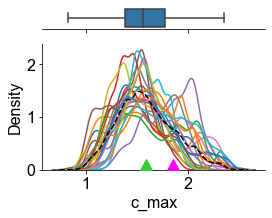

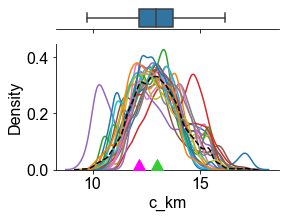

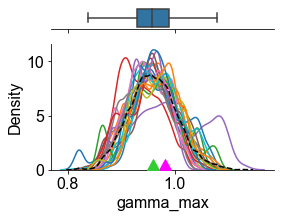

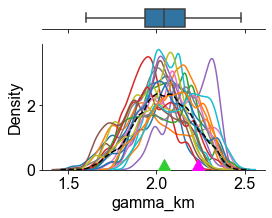

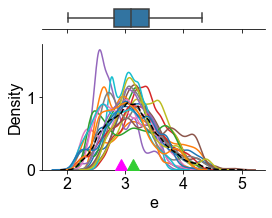

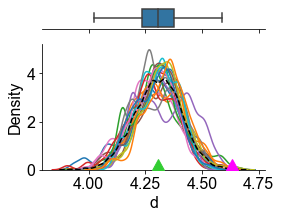

In [38]:
colors = sns.color_palette("tab10")

# original = [5.19,9.51,0.65,1.82,0.84,2.74]
# original = [5.98,9.62,0.86,2.30,1.22,4.92] #continued

for i in range(len(burn_in_chains[0].T)):
    f, (ax_box, ax_hist) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios': [.15,.85]},figsize=(4.,3.))
    
    sns.boxplot(x=np.vstack(burn_in_chains).T[i], ax=ax_box,showfliers=False)
    
    for j in range(len(burn_in_chains)):
        try: 
            sns.kdeplot(ax=ax_hist,x = burn_in_chains[j].T[i])#,color=colors[j])
        except: print(i,j)
            
    plt.plot(worst[i],0,'magenta',marker='d',markersize=15,zorder=10)
    plt.plot(closest[i],0,'limegreen',marker='d',markersize=15,zorder=10)
        
    sns.kdeplot(ax=ax_hist,x=np.vstack(burn_in_chains).T[i],color='k',ls='--')

    ax_hist.set_xlabel(params[i])
    ax_box.set(yticks=[])

    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    sns.despine(ax=ax_box, left=True)
#     plt.tight_layout()

    
#     plt.savefig('MCMC_Figures/KDE_BP_%s.png' %params[i],dpi=300,bbox_inches='tight')
#     plt.savefig('MCMC_Figures/KDE_BP_%s.pdf' %params[i],dpi=300,bbox_inches='tight')
    plt.show()

In [552]:
b = 0.0002
c_s = 0.1
gamma_s = 0.0005
delta = 0.04
c_p,c_m,gamma_p,gamma_m,e,d = bi_all_chains[71918]

In [39]:
df = pd.DataFrame(bi_all_chains,columns=params)
# test = bi_all_chains[:1000]
# df = pd.DataFrame(test,columns=params)

<Figure size 720x720 with 0 Axes>

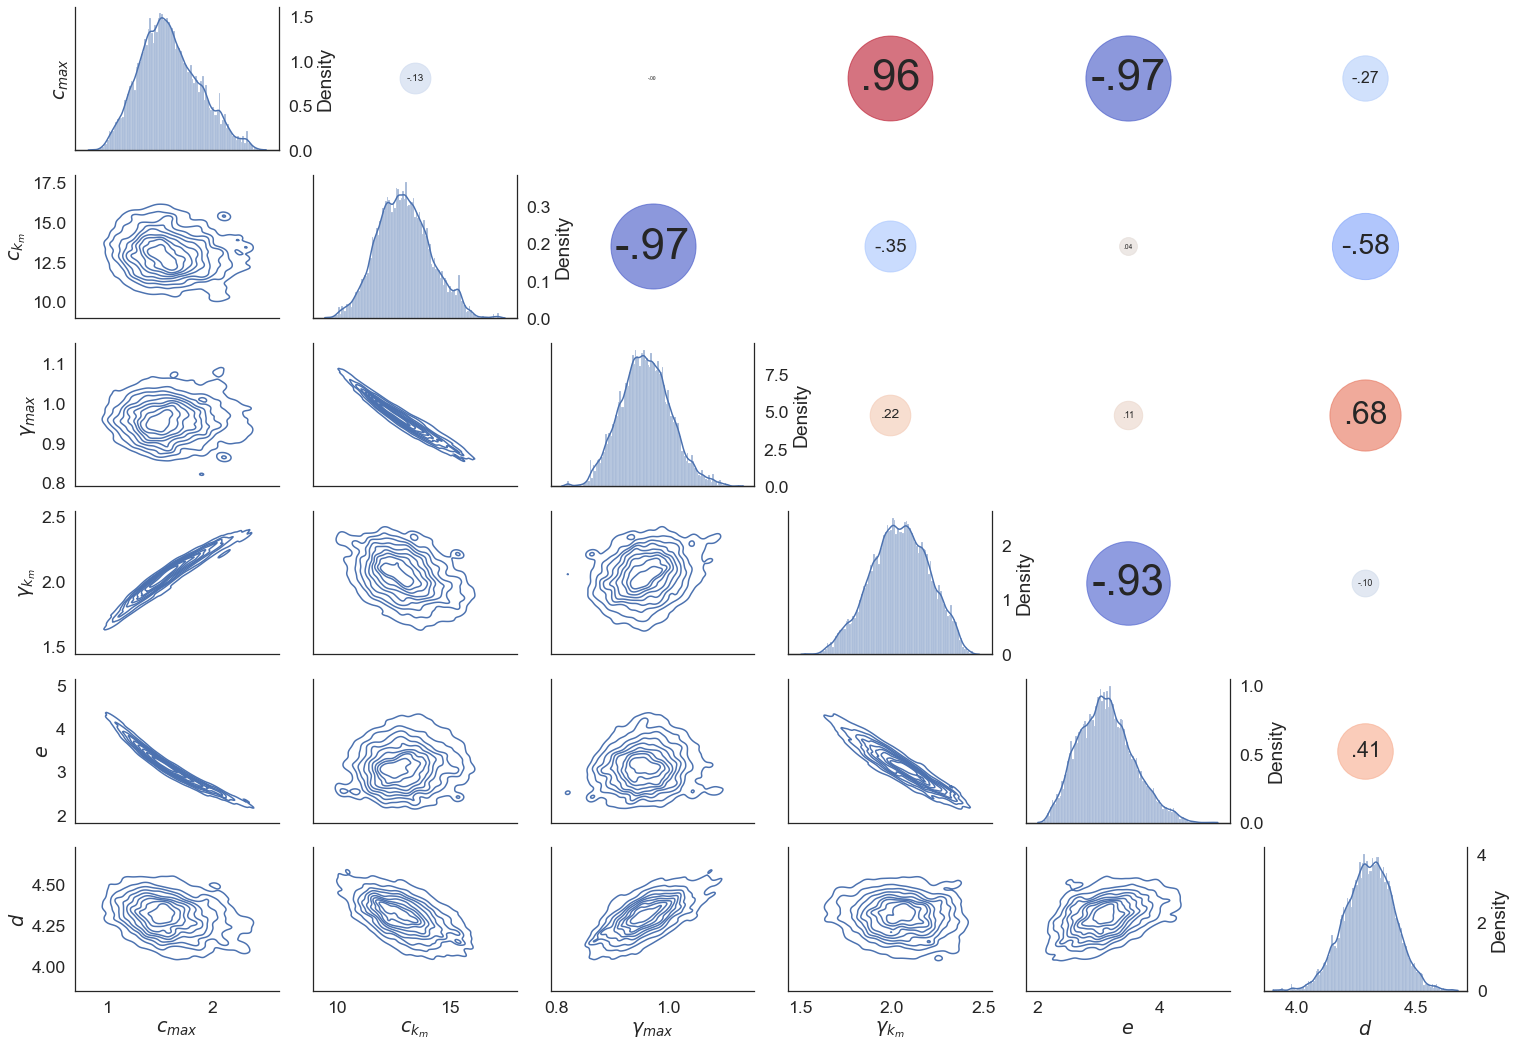

In [545]:
### https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 7500
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
def my_hist(x, label, color):
    ax0 = plt.gca()
    ax = ax0.twinx()
    
    sns.despine(ax=ax, left=True, top=True, right=False)
    
#     ax.hist(x, label=label, color=color)
    sns.histplot(x, label=label, color=color,stat = 'density',kde=True,line_kws={'color': 'black'})

plt.figure(figsize=(10,10))
sns.set(style='white', font_scale=1.6)
# iris = sns.load_dataset('iris')
g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
# g.map_lower(sns.regplot, ci=False, line_kws={'color': 'black'}, scatter_kws={'s':0.25})
g.map_lower(sns.kdeplot) #, ci=False, line_kws={'color': 'black'})
# g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_diag(my_hist)
g.map_upper(corrdot)

plt.setp(g.axes[0,0], yticks=[])


# plt.savefig('MCMC_Figures/MCMC_Results.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('MCMC_Figures/MCMC_Results.png',dpi=300,bbox_inches='tight')
# plt.savefig('MCMC_Figures/MCMC_Results_LQ.png',dpi=150,bbox_inches='tight')


In [57]:
rs = np.linspace(0,4,1000)
c_s = 0.1
gamma_s = 0.0005
mu_F = 1.75

all_cs = []

for i in range(len(bi_all_chains)):
    cs = logistic_decay(rs,c_s,bi_all_chains.T[0,i],bi_all_chains.T[1,i])
#     cs = exp_decay_gradient(c_s,bi_all_chains.T[0,i],bi_all_chains.T[1,i],rs,mu_F)
    all_cs.append(cs)

In [58]:
all_gammas = []

for i in range(len(bi_all_chains)):

    gammas = logistic_decay(rs,gamma_s,bi_all_chains.T[2,i],bi_all_chains.T[3,i])
#     gammas = exp_decay_gradient(gamma_s,bi_all_chains.T[2,i],bi_all_chains.T[3,i],rs,mu_F)
    all_gammas.append(gammas)

In [59]:
import scipy as scpy

def plot_fill_between(ph,xs, mean, ci, alpha=0.3, color='b'):
    ph.fill_between(xs, (mean-ci),(mean+ci), alpha=alpha,color=color) 

In [60]:
all_cs = np.array(all_cs)
all_gammas = np.array(all_gammas)

mean_cs = np.mean(all_cs,axis=0)
std_cs = np.std(all_cs,axis=0)

mean_gammas = np.mean(all_gammas,axis=0)
std_gammas = np.std(all_gammas,axis=0)

mean_ratio = np.mean(all_gammas/all_cs,axis=0)
std_ratio = np.std(all_gammas/all_cs,axis=0)


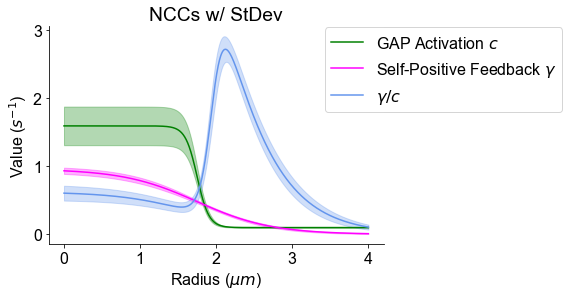

In [61]:
#Plot non-constant parameter distributions

plt.figure(figsize=(6,4))
plot_fill_between(plt,rs, mean_cs, std_cs,color='green')
plt.plot(rs,mean_cs,color='green')

plot_fill_between(plt,rs, mean_gammas, std_gammas,color='magenta')
plt.plot(rs,mean_gammas,color='magenta')

plot_fill_between(plt,rs, mean_ratio, std_ratio,color='cornflowerblue')
plt.plot(rs,mean_ratio,color='cornflowerblue')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('NCCs w/ StDev')
plt.xlabel('Radius ($\mu m$)')
plt.ylabel('Value ($s^{-1}$)')


plt.legend([r'GAP Activation $c$',r'Self-Positive Feedback $\gamma$',r'$\gamma/c$'],loc='center left', bbox_to_anchor=(0.8, 0.8))

# plt.savefig('MCMC_Figures/NCC_Plots.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('MCMC_Figures/NCC_Plots.png',dpi=300,bbox_inches='tight')